<a href="https://colab.research.google.com/github/vladislavlisin/ICR/blob/main/ICR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Данная тетрадка посвещена соревнованию на kaggle:** https://www.kaggle.com/competitions/icr-identify-age-related-conditions

Задача бинарной классификации: У пациента есть одно из трёх заболеваний (1 класс) или нет ни одного заболевания (класс 0)

В настоящее время такие модели, как XGBoost и случайный лес, используются для прогнозирования заболеваний, но производительность моделей недостаточно высока. Имея дело с критическими проблемами, когда на карту поставлены жизни, модели должны надежно и последовательно делать правильные прогнозы для разных случаев.

Представления оцениваются с использованием сбалансированного логарифмического проигрыша . Общий эффект таков, что каждый класс примерно одинаково важен для окончательного результата.

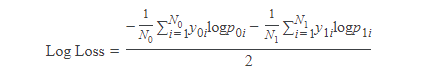

где (N_{c}) — количество наблюдений класса (c), (\ log) — натуральный логарифм, (y_{ci}) равно 1, если наблюдение (i) принадлежит классу (c), и 0 в противном случае, (p_{ci}) — прогнозируемая вероятность того, что наблюдение (i) принадлежит классу (c).

Представленные вероятности для данной строки не обязаны суммироваться до единицы, потому что они масштабируются до подсчета очков (каждая строка делится на сумму строки). Чтобы избежать крайностей логарифмической функции, каждая прогнозируемая вероятность
заменяется на

Lisin Vladislav

In [ ]:
def balanced_log_loss(y1, y0, p1, p0, N0, N1):

  sum1 = (y1 * np.log(p1)).sum()
  sum0 = (y0 * np.log(p0)).sum()

  LogLoss = -0.5*( (1/N0)*sum0 + (1/N1)*sum1 )

  return LogLoss

**Требования к коду**

Заявки на участие в этом конкурсе должны подаваться через Notebooks. Чтобы кнопка «Отправить» была активна после коммита, должны быть выполнены следующие условия:

1. Ноутбук с процессором <= 9 часов работы
2. Ноутбук с графическим процессором <= 9 часов работы
3. Доступ в Интернет отключен
4. Файл отправки должен быть названsubmission.csv

Информация по данным:

train.csv — тренировочный набор.
Id Уникальный идентификатор для каждого наблюдения.

AB- GL Пятьдесят шесть анонимных характеристик здоровья. Все числовые, за исключением EJ, который является категориальным.

In [ ]:
!pip install optuna

In [ ]:
import sklearn
import pandas as pd
import seaborn as sbn
import numpy as np
import optuna as o


from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
df_train = pd.read_csv("/content/drive/MyDrive/ICR - Identifying Age-Related Conditions/train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/ICR - Identifying Age-Related Conditions/test.csv")

have a look at data

1. describe
2.

In [ ]:
df_train

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,fd3dafe738fd,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,...,0.173229,1.26092,0.067730,8.967128,217.148554,8095.932828,24.640462,69.191944,21.978000,0
613,fd895603f071,0.435846,5462.03438,85.200147,46.551007,15.973224,5.979825,0.025882,12.622906,3.777550,...,10.223150,1.24236,0.426699,35.896418,496.994214,3085.308063,29.648928,124.808872,0.145340,0
614,fd8ef6377f76,0.427300,2459.10720,130.138587,55.355778,10.005552,8.070549,0.025578,15.408390,1.229900,...,0.173229,0.49706,0.067730,19.962092,128.896894,6474.652866,26.166072,119.559420,21.978000,0
615,fe1942975e40,0.363205,1263.53524,85.200147,23.685856,8.138688,7.981959,0.025578,7.524588,1.229900,...,9.256996,0.78764,0.670527,24.594488,72.611063,1965.343176,25.116750,37.155112,0.184622,0


In [ ]:
df_test

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
0,00eed32682bb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,010ebe33f668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,02fa521e1838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,040e15f562a2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,046e85c7cc7f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
y = df_train.Class

df_test = df_test.drop(["Id"], axis=1)
ds_train = df_train.drop(["Id", "Class"], axis=1)

In [ ]:
ds_train.describe()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
count,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,...,617.000000,616.000000,617.000000,615.000000,617.000000,617.000000,617.000000,617.000000,617.000000,616.000000
mean,0.477149,3502.013221,118.624513,38.968552,10.128242,5.545576,0.060320,10.566447,8.053012,5350.388655,...,10.111079,5.433199,3.533905,0.421501,20.724856,131.714987,14679.595398,31.489716,50.584437,8.530961
std,0.468388,2300.322717,127.838950,69.728226,10.518877,2.551696,0.416817,4.350645,65.166943,3021.326641,...,2.934025,11.496257,50.181948,1.305365,9.991907,144.181524,19352.959387,9.864239,36.266251,10.327010
min,0.081187,192.593280,85.200147,3.177522,8.138688,0.699861,0.025578,3.396778,1.229900,1693.624320,...,3.583450,0.173229,0.497060,0.067730,4.102182,72.611063,13.038894,9.432735,0.897628,0.001129
25%,0.252107,2197.345480,85.200147,12.270314,8.138688,4.128294,0.025578,8.129580,1.229900,4155.702870,...,8.523098,0.173229,0.497060,0.067730,14.036718,72.611063,2798.992584,25.034888,23.011684,0.124392
50%,0.354659,3120.318960,85.200147,20.533110,8.138688,5.031912,0.025578,10.461320,1.229900,4997.960730,...,9.945452,3.028141,1.131000,0.250601,18.771436,72.611063,7838.273610,30.608946,41.007968,0.337827
75%,0.559763,4361.637390,113.739540,39.139886,8.138688,6.431634,0.036845,12.969516,5.081244,6035.885700,...,11.516657,6.238814,1.512060,0.535067,25.608406,127.591671,19035.709240,36.863947,67.931664,21.978000
max,6.161666,28688.187660,1910.123198,630.518230,178.943634,38.270880,10.315851,38.971568,1463.693448,53060.599240,...,35.851039,137.932739,1244.227020,31.365763,135.781294,1497.351958,143790.071200,81.210825,191.194764,21.978000


In [ ]:
ds_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 56 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AB      617 non-null    float64
 1   AF      617 non-null    float64
 2   AH      617 non-null    float64
 3   AM      617 non-null    float64
 4   AR      617 non-null    float64
 5   AX      617 non-null    float64
 6   AY      617 non-null    float64
 7   AZ      617 non-null    float64
 8   BC      617 non-null    float64
 9   BD      617 non-null    float64
 10  BN      617 non-null    float64
 11  BP      617 non-null    float64
 12  BQ      557 non-null    float64
 13  BR      617 non-null    float64
 14  BZ      617 non-null    float64
 15  CB      615 non-null    float64
 16  CC      614 non-null    float64
 17  CD      617 non-null    float64
 18  CF      617 non-null    float64
 19  CH      617 non-null    float64
 20  CL      617 non-null    float64
 21  CR      617 non-null    float64
 22  CS

In [ ]:
# посчитаем количество nans по столбцам и уберём те столбцы где их нет
ds_train.isnull().sum()[lambda x: x != 0]

BQ    60
CB     2
CC     3
DU     1
EL    60
FC     1
FL     1
FS     2
GL     1
dtype: int64

In [ ]:
# перед импютацией закодируем категориальные данные
# посчитаем количество уникальных значений, в основном как оказалось признаки не дискретны

def count_unique(df : pd.DataFrame):
  for i in df.columns:
    print(i, len(df[i].unique()))

count_unique(ds_train)

AB 217
AF 599
AH 227
AM 605
AR 130
AX 427
AY 148
AZ 484
BC 259
BD  617
BN 53
BP 612
BQ 516
BR 566
BZ 115
CB 554
CC 603
CD  584
CF 586
CH 135
CL 123
CR 595
CS 576
CU 307
CW  426
DA 611
DE 616
DF 137
DH 191
DI 571
DL 604
DN 576
DU 254
DV 39
DY 590
EB 439
EE 513
EG 610
EH 127
EJ 2
EL 312
EP 275
EU 455
FC 601
FD  337
FE 615
FI 498
FL 389
FR 435
FS 162
GB 560
GE 264
GF 611
GH 596
GI 615
GL 356


In [ ]:
mapping = {"A": 1,
           "B": 0}

map_train = ds_train.copy(deep=True)

map_train['EJ'] = ds_train.EJ.map(mapping)
df_test["EJ"] = df_test.EJ.map(mapping)

map_train.EJ

0      0
1      1
2      0
3      0
4      0
      ..
612    1
613    0
614    1
615    0
616    1
Name: EJ, Length: 617, dtype: int64

In [ ]:
from sklearn.impute import SimpleImputer

# EJ - КАТЕГОРИАЛЬНЫЙ, БЕЗ ПРОПУЩЕННЫХ ЗНАЧЕНИЙ, ОСТАЛЬНЫЕ ЧИСЛОВЫЕ

imp_med = SimpleImputer(missing_values=np.nan, strategy='median')

imp_med.fit(map_train)

df_test = pd.DataFrame(imp_med.transform(df_test), columns=df_test.columns)
imp_ds_train = pd.DataFrame(imp_med.transform(map_train), columns=map_train.columns)

In [ ]:
imp_ds_train.isnull().sum()[lambda x: x != 0]

Series([], dtype: int64)

In [ ]:
imp_ds_train.head(10)

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
0,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,...,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343
1,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,...,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000
2,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,...,11.626917,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941
3,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,...,14.852022,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829
4,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,...,13.666727,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614
5,0.209377,2615.81430,85.200147,8.541526,8.138688,4.013127,0.025578,12.547282,1.229900,5237.54088,...,10.981896,0.173229,0.49706,1.164956,21.915512,72.611063,24177.595550,28.525186,82.527764,21.978000
6,0.348249,1733.65412,85.200147,8.377385,15.312480,1.913544,0.025578,6.547778,1.229900,5710.46099,...,10.777915,4.408484,0.86130,0.467337,17.878444,192.453107,3332.467494,34.166222,100.086808,0.065096
7,0.269199,966.45483,85.200147,21.174189,8.138688,4.987617,0.025578,9.408886,1.229900,5040.77914,...,10.342388,6.591896,0.49706,0.277693,18.445866,109.693986,21371.759850,35.208102,31.424696,0.092873
8,0.346113,3238.43674,85.200147,28.888816,8.138688,4.021986,0.025578,8.243016,3.626448,6569.37001,...,11.450501,4.762291,1.18262,0.067730,17.245908,147.218610,4589.611956,29.771721,54.675576,0.073416
9,0.324748,5188.68207,85.200147,12.968687,8.138688,4.593392,0.025578,10.685041,1.229900,4951.69863,...,12.329825,0.173229,1.57151,0.318331,24.515421,98.929757,5563.130949,21.994831,33.300970,21.978000


In [ ]:
# Как распределены классы

s = y.value_counts()
all = y.value_counts().sum()
print(s)
print(s[0]/all, s[1]/all)

# зверский дисбаланс
#  делаем чтонибуть с этим

from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
print(class_weights)
class_weight = {0: class_weights[0], 1: class_weights[1]}

0    509
1    108
Name: Class, dtype: int64
0.8249594813614263 0.17504051863857376
[0.60609037 2.85648148]


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score as bas, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt

def evaluate_metrics(preds, prob_preds):

  # conf mat and balanced acc

  print("Сбалансированная точность", bas(y_test, preds))
  print("Матрица неточностей \n", confusion_matrix(y_test, preds))

  # base metrica
  # threshold

  preds1 = preds
  preds0 = 1 - preds1
  N0 = preds0.sum()
  N1 = preds1.sum()

  ll = balanced_log_loss(y1 = preds1, y0 = preds0 , p1 = prob_preds[:, 1], p0 = prob_preds[:, 0], N0=N0, N1=N1)
  print("Сбалансированный LogLoss", ll)

  # all in all

  print(classification_report(y_test, preds))

  # AUC ROC

  lr_probs = prob_preds[:, 1]
  # рассчитываем ROC AUC
  lr_auc = roc_auc_score(y_test, lr_probs)
  print('ROC AUC=%.3f' % (lr_auc))
  # рассчитываем roc-кривую
  fpr, tpr, treshold = roc_curve(y_test, lr_probs)
  roc_auc = auc(fpr, tpr)
  # строим график
  plt.plot(fpr, tpr, color='darkorange',
           label='ROC кривая (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Пример ROC-кривой')
  plt.legend(loc="lower right")
  plt.show()


Сбалансированная точность 0.8035714285714286
Матрица неточностей 
 [[66 11]
 [ 4 12]]
Сбалансированный LogLoss 0.3558592211046744
              precision    recall  f1-score   support

           0       0.94      0.86      0.90        77
           1       0.52      0.75      0.62        16

    accuracy                           0.84        93
   macro avg       0.73      0.80      0.76        93
weighted avg       0.87      0.84      0.85        93

ROC AUC=0.887


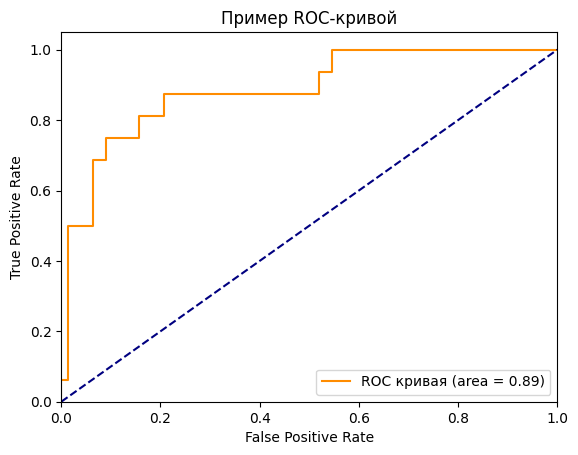

In [ ]:
# lets do some baseline model - linear model

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(imp_ds_train, y, random_state=1, stratify=y, test_size=0.15)

lr = LogisticRegression(penalty="l2",
                        C=1,
                        n_jobs=-1,
                        class_weight = class_weight
                        )

lr.fit(x_train, y_train)

preds = lr.predict(x_test)
prob_preds = lr.predict_proba(x_test)

evaluate_metrics(preds, prob_preds)

# Сбалансированный LogLoss 0.28583871302404357 - без class_weight
# Сбалансированный LogLoss 0.3558592211046744 - c class_weight

In [ ]:
# okay, lets try non-linear model

!pip install lightgbm

Сбалансированная точность 0.9180194805194806
Матрица неточностей 
 [[74  3]
 [ 2 14]]
Сбалансированный LogLoss 0.04439362317578613
              precision    recall  f1-score   support

           0       0.97      0.96      0.97        77
           1       0.82      0.88      0.85        16

    accuracy                           0.95        93
   macro avg       0.90      0.92      0.91        93
weighted avg       0.95      0.95      0.95        93

ROC AUC=0.977


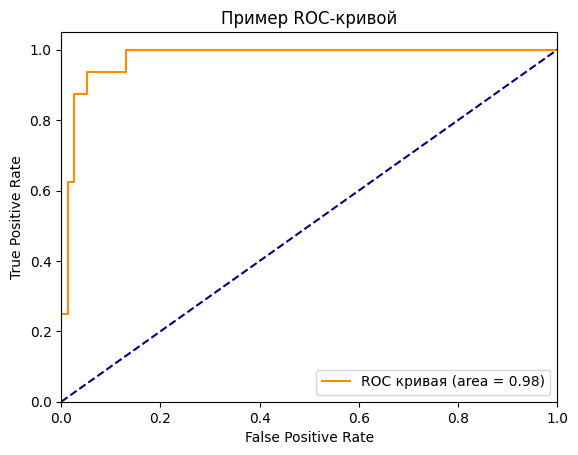

In [ ]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(boosting_type='gbdt',
                      num_leaves=31,
                      max_depth=-1,
                      learning_rate=0.1,
                      n_estimators=100,
                      class_weight=class_weight,
                      n_jobs=-1,
                      random_state=1
                      )

lgbm.fit(x_train, y_train)

preds = lgbm.predict(x_test)
prob_preds = lgbm.predict_proba(x_test)

evaluate_metrics(preds, prob_preds)

# Сбалансированный LogLoss 0.10082225060556227 - без class_weight
# Сбалансированный LogLoss 0.04439362317578613 - c class_weight

In [ ]:
from sklearn.

# **TO SUBMIT**

In [ ]:
# lightgbm показал хорошие результаты, теперь обучим модель на всех данных
# и сделаем прогнозы для забмита

lgbm_final = LGBMClassifier(boosting_type='gbdt',
                            num_leaves=31,
                            max_depth=-1,
                            learning_rate=0.1,
                            n_estimators=100,
                            class_weight=class_weight,
                            n_jobs=-1,
                            random_state=1
                            )

lgbm_final.fit(imp_ds_train, y)
prob_preds = lgbm_final.predict_proba(df_test)

In [ ]:
  # make sub

ss = pd.read_csv("/content/drive/MyDrive/ICR - Identifying Age-Related Conditions/sample_submission.csv")
ss

,Id,class_0,class_1
0,00eed32682bb,0.5,0.5
1,010ebe33f668,0.5,0.5
2,02fa521e1838,0.5,0.5
3,040e15f562a2,0.5,0.5
4,046e85c7cc7f,0.5,0.5


In [ ]:
p1 = prob_preds[:, 1]
p0 = prob_preds[:, 0]

ss.class_0 = p0
ss.class_1 = p1
# ss.to_csv('/kaggle/working/submission.csv', index=False)

# rezults on public

# 0.38

OSError: ignored